<a href="https://colab.research.google.com/github/gregueiras/7052CEM/blob/master/ff_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from src.projects import Projects
from src.experiments import SIMBED_Experiments, SIMBEDP_Experiments, get_nodes
from src.node_location import get_location, get_distance
from src.experimentCFG import get_configs, ExperimentCFG
from src.util import load_data_path
from src.util_rss import load_rss
from src.path_loss import friis, log_distance, gammas
from src.util_ai import cv, plot_prediction, scatter_distance, evaluate_model, wrap_keras, wrap_sklearn
from src.models import baseline_model, n1
from src.final import full_pipeline, fast_fading_model
from src.fast_fading import plot_best_distributions, best_fit_distribution
from datetime import datetime
from typing import List
import os
from IPython.display import display

import numba
from numba import jit
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model, svm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.neighbors import LocalOutlierFactor
from sklearn.compose import TransformedTargetRegressor
import itertools

from math import sqrt

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import TensorBoard

import xgboost as xg

plt.rcParams['figure.figsize'] = [15, 8]
ML_KEY = "TS-ML"

In [2]:
proj = Projects.SIMBED
exp = SIMBED_Experiments._3

cfgs = get_configs(project=proj, experiment=exp)
data = load_rss(cfgs, 0.2, sec_avg=False)

display(data.head())

,distance,friis,log_d_1.7,log_d_2.0,log_d_2.5,PL
0,5.85730,-62.149132,-65.846039,-62.149132,-55.987617,-71.0
1,6.91885,-63.595860,-67.075760,-63.595860,-57.796032,-70.0
2,2.28478,-53.972069,-58.895538,-53.972069,-45.766293,-67.0
3,5.00069,-60.775780,-64.678688,-60.775780,-54.270931,-69.0
4,2.27958,-53.952278,-58.878716,-53.952278,-45.741554,-71.0


In [3]:
df_means = data.groupby("distance").mean()
df_means = df_means.reset_index()

@jit(nopython=True)
def calc_ff(pl, pl_mean):
  output = np.zeros_like(pl)
  i = 0
  for p, p_m in zip(pl, pl_mean):
    output[i] = p - p_m
    i += 1
  return output


df_means["PL_mean"] = df_means["PL"]
df_means = df_means[["distance", "PL_mean"]]

data.set_index("distance", inplace=True)
df_means.set_index("distance", inplace=True)

data = data.join(df_means)

data['PL_ff'] = calc_ff(data.PL.values, data.PL_mean.values)
data = data.drop(["PL_mean"], axis=1)

data = data.reset_index()

data.head()

,distance,friis,log_d_1.7,log_d_2.0,log_d_2.5,PL,PL_ff
0,2.0547,-53.050152,-58.111904,-53.050152,-44.613892,-75.0,1.136986
1,2.0547,-53.050152,-58.111904,-53.050152,-44.613892,-76.0,0.136986
2,2.0547,-53.050152,-58.111904,-53.050152,-44.613892,-76.0,0.136986
3,2.0547,-53.050152,-58.111904,-53.050152,-44.613892,-77.0,-0.863014
4,2.0547,-53.050152,-58.111904,-53.050152,-44.613892,-78.0,-1.863014


sse: norm_gen	2.5167153693318083
sse: rice_gen	2.528955299634514
sse: rayleigh_gen	2.6303143517057292


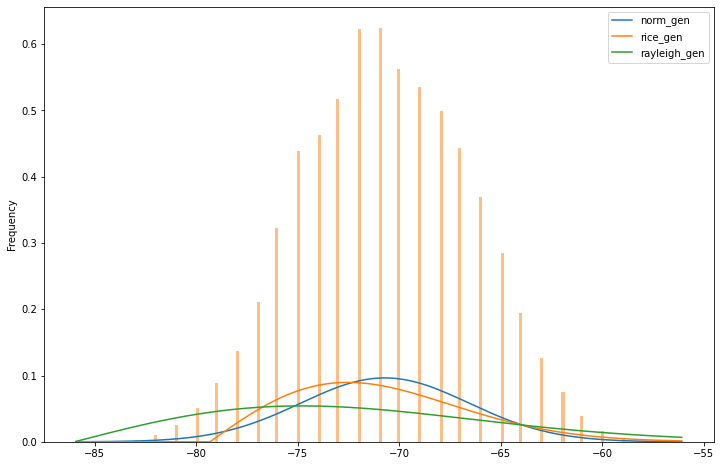

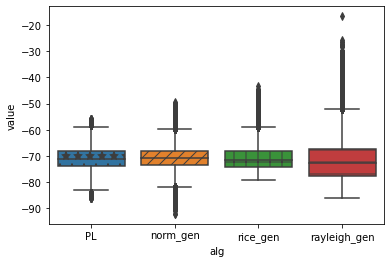

value                       ...                                 
          count       mean       std  ...        50%        75%        max
alg                                   ...                                 
PL    3443250.0 -70.705286  4.138616  ... -71.000000 -68.000000 -56.000000
norm  3443250.0 -70.700140  4.137422  ... -70.698151 -67.911236 -48.480763

[2 rows x 8 columns]

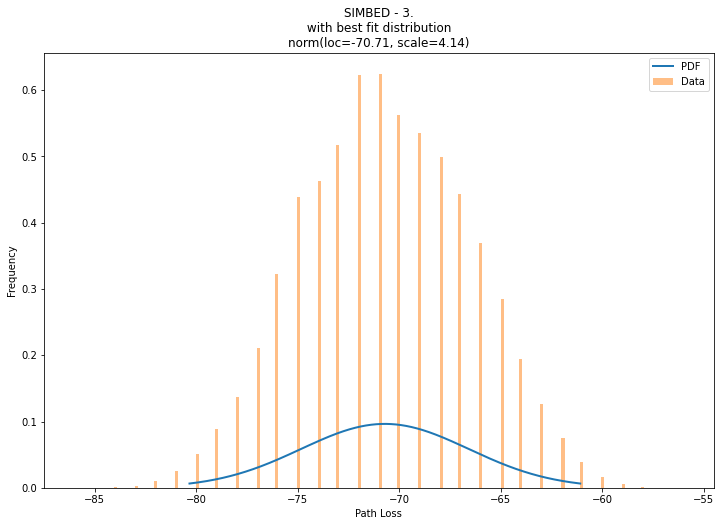

<Figure size 864x576 with 0 Axes>

In [4]:
plot_best_distributions(proj, exp, data["PL"], bins=200)

sse: norm_gen	0.04729022257933929
sse: rice_gen	0.16143770616632722
sse: rayleigh_gen	0.573165942228289


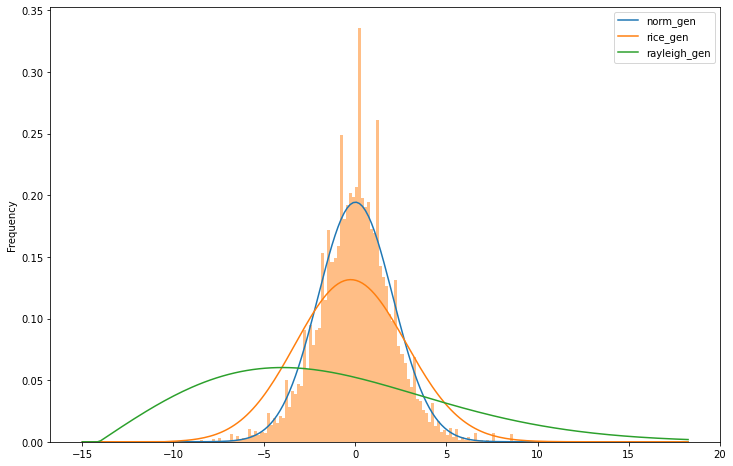

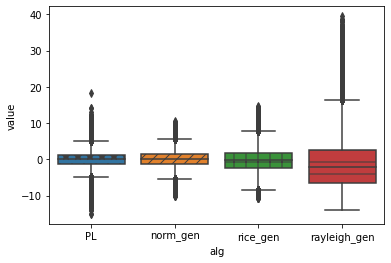

value                          ...                               
          count          mean       std  ...       50%       75%        max
alg                                      ...                               
PL    3443250.0  3.073982e-07  2.051662  ...  0.067795  1.227676  18.356354
norm  3443250.0 -8.861090e-04  2.052323  ...  0.000508  1.383799  10.272943

[2 rows x 8 columns]

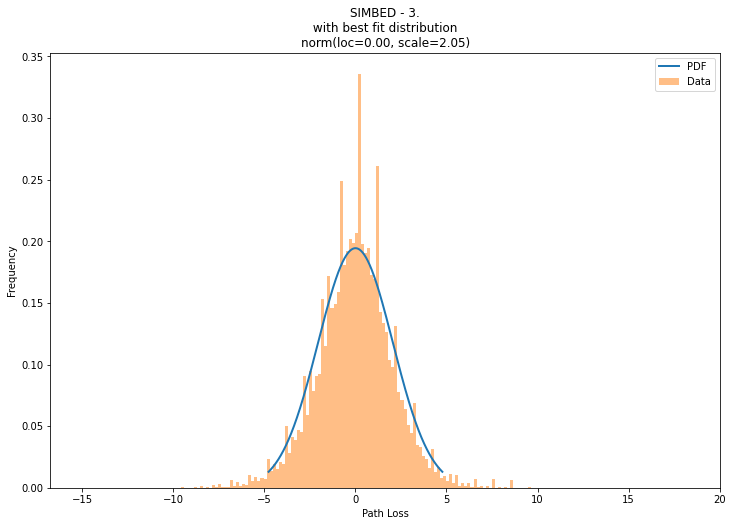

<Figure size 864x576 with 0 Axes>

In [5]:
plot_best_distributions(proj, exp, data["PL_ff"], bins=200)

sse: norm_gen	0.04729022257933929
sse: rice_gen	0.16143770616632722
sse: rayleigh_gen	0.573165942228289


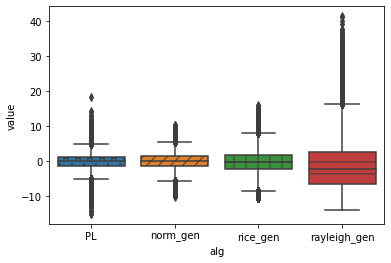

array([ 0.84421104, -2.65316083,  2.41648706,  0.31813029,  1.38652415,
       -1.27939846,  4.68850937,  2.01754853, -1.46264003,  2.56406399])

In [6]:
model = fast_fading_model("AAA", data, rebuild=True)

model(10)

In [7]:
def load_single_run(proj, exp, cfg_index, train_filter=None, domain_filter=None):
  cfgs = get_configs(project=proj, experiment=exp)
  cfg = [cfgs[cfg_index]]

  df = load_rss(cfg, 1, use_cache=False)
  df_r = load_rss(cfg, 1, sec_avg=False, use_cache=False)
  
  if (train_filter is not None):
    df = train_filter(df)
    df_r = train_filter(df_r)


  if (domain_filter is not None):
      df = domain_filter(df)
      df_r = domain_filter(df_r)

  return cfg[0], df, df_r

In [8]:
cfg, df, df_r = load_single_run(proj, exp, 20)

display(df_r.head())

display(df.distance.max(), len(df))
display(df_r.distance.max(), len(df_r))

1/1	07022019_04.49.12

,distance,friis,log_d_1.7,log_d_2.0,log_d_2.5,PL
0,6.91885,-63.595861,-67.075759,-63.595861,-57.796030,-70.0
1,7.48600,-64.280179,-67.657429,-64.280179,-58.651428,-68.0
2,2.75681,-55.603319,-60.282098,-55.603319,-47.805353,-71.0
3,6.83403,-63.488720,-66.984689,-63.488720,-57.662104,-73.0
4,7.40370,-64.184159,-67.575812,-64.184159,-58.531403,-71.0


24.1042

357

17.6409

164581